# Non - inertial frame solution to the Cartpole Problem

When I first solved the cartpole problem I was expecting the solution where the pole is vertical and not moving. However, I was pleasantly surprised to see a different solution. This solution is natural to physicists who know non-inertial frames and pseudo forces as well as the equivalence principle. I just didn't expect the RL model to find it.

Before I go into that let me point out that there is another solution possible where the pole is vertical and that is when the cart moves with a uniform velocity. That is actually just a change of reference frame from one inertial frame to another.


Now to the interesting solution. In a frame that is accelerating (a non inertial frame), one can treat the negative of the acceleration vector as a force (called a pseudo force) and then apply Newton's other two laws as if we were in an inertial frame. If the acceleration is a constant then that effectively adds to the original gravity vector and becomes an effective gravity vector. Thus, there is an infinite family of solutions to the cartpole problem where the pole is at an angle of 

$$
\theta = \tan^{-1}(a/g)
$$

and the cart is being accelerated at $a$.

Stricly speaking this is not true for the original cartpole problem since it has limits on the horizonal distance and angle deviation. Thus my aforementioned "pleasant surprise" was to see the system find the tilted solution only for a short time. To coax out the general solution I had to tweak the problem to allow the system to fully discover the non-trivial solution.


I thus wrapped the openai environment so as to change the restriction on angle deviation and maximum distance as well as change the plotting to allow the cart to run beyond the orignial range of the screen. 

# The "usual" solution

First we discuss the usual solution of the cartpole problem where the model makes the cart move very little while keeping the pole vertical.


In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [5]:
# To plot pretty figures
%matplotlib inline
#import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)




In [6]:
from openai import Agent, AgentPool, train_model_on_agent
from plotting import plot_animation

In [7]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


We make an agent that will run on a model and set the limits on max distance to $\infty$ and max angle to $\pi/2$. This is the agent that we will use to test all our models. This is where I have made some tweaks so that the agent wraps the gym environment so as to allow deviations more than 12 degrees and horizontal displacements more than 2.4 units.

In [8]:
an=Agent(min_distance=-float('inf'),max_distance=float('inf'),
         min_angle=-np.pi/2,max_angle=np.pi/2,seed=42)

Lets first see what happens with an untrained model

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model_untrained = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(2, activation="softmax"),
])


In [59]:
thetas=np.arange(-90,100,30)
rad=thetas*np.pi/180

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Text(0.5, 0.98, 'Untrained Random Model')

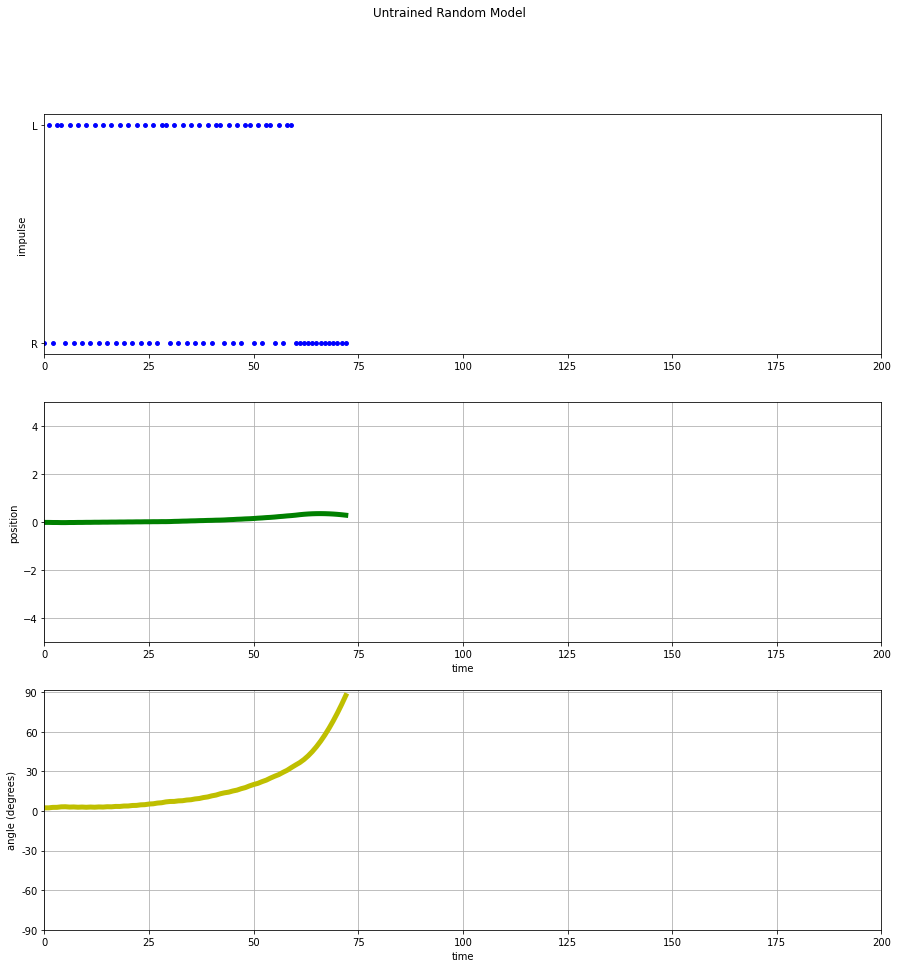

In [61]:
obs,choices,frames=an.play_a_round(model_untrained)
_,axs=plt.subplots(3,1, figsize=(15,15))
axs[0].scatter(range(len(obs)),2*choices-1,s=15,color='b')
axs[0].set_xlim(0,200)
axs[0].set_ylabel('impulse')
axs[0].set_yticks([-1,1])
axs[0].set_yticklabels(['R','L'])


axs[1].plot(obs[:,0],lw=5,color='g')
axs[1].grid(True)
axs[1].set_xlabel('time')
axs[1].set_ylabel('position')
axs[1].set_xlim(0,200)
axs[1].set_ylim(-5,5)

axs[2].plot(obs[:,2],lw=5,color='y')
axs[2].grid(True)
axs[2].set_xlabel('time')
axs[2].set_ylabel('angle (degrees)')
axs[2].set_xlim(0,200)
axs[2].set_yticks(rad)
axs[2].set_yticklabels(thetas)
plt.suptitle('Untrained Random Model')

Above we plot the impulses, positions and angles. We see that the pole quickly falls to 90 degress. If you have the animation environment set up then you can see the video below as well.

In [43]:
plot_animation(frames)

Now lets train the mode. We do this by training with a pool of 10 agents over 150 iterations on the standard environment. But then to really show the solution we further train by squeezing the allowed angular and positional range finally getting into a 3 degree angular deviation and .5 translational deviation regime.

In [62]:
n_iterations=150
n_agents=10
optimizer = keras.optimizers.Adam(0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

model1 = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", input_shape=[4]),
    keras.layers.Dense(2, activation="softmax"),
])



In [37]:
ap1=AgentPool(n_agents)
train_model_on_agent(ap1,model1,optimizer,loss_fn,n_iterations)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Iteration: 149, mean rewards: 168.2

In [41]:

for a,d in ((10,2),(5,1),(3,.5)):
    print('Training with max distance {distance} and angular deviation {angle} degress\n'.format(angle=a, distance=d))
    ap1=AgentPool(n_agents,min_angle=-a*np.pi/180.,max_angle=a*np.pi/180.,min_distance=-d,max_distance=d)
    train_model_on_agent(ap1,model1,optimizer,loss_fn,n_iterations)

Training with max distance 2 and angular deviation 10 degress

Iteration: 149, mean rewards: 195.4Training with max distance 1 and angular deviation 5 degress

Iteration: 149, mean rewards: 193.8Training with max distance 0.5 and angular deviation 3 degress

Iteration: 149, mean rewards: 156.2

In [64]:
#model1.save_weights('models/max_distance_1')
model1.load_weights('models/max_distance_1')

Text(0.5, 0.98, 'Expected solution')

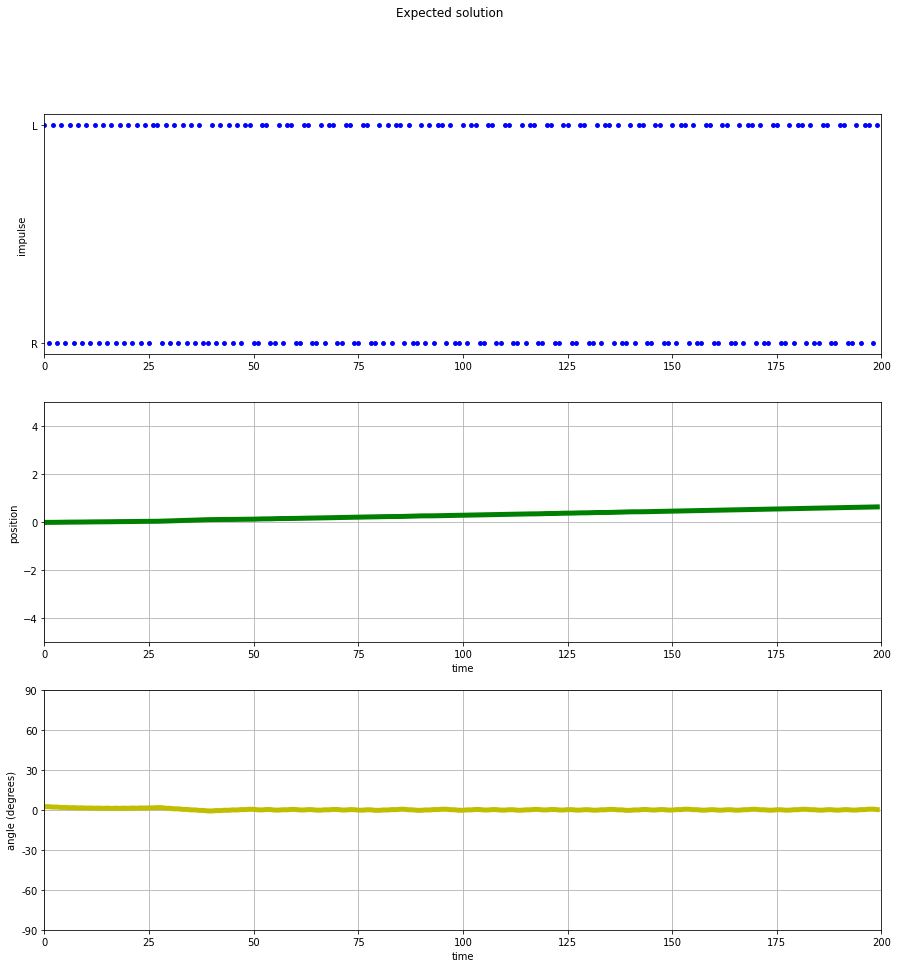

In [66]:
obs,choices,frames=an.play_a_round(model1)
_,axs=plt.subplots(3,1, figsize=(15,15))
axs[0].scatter(range(len(obs)),2*choices-1,s=15,color='b')
axs[0].set_xlim(0,200)
axs[0].set_ylabel('impulse')
axs[0].set_yticks([-1,1])
axs[0].set_yticklabels(['R','L'])


axs[1].plot(obs[:,0],lw=5,color='g')
axs[1].grid(True)
axs[1].set_xlabel('time')
axs[1].set_ylabel('position')
axs[1].set_xlim(0,200)
axs[1].set_ylim(-5,5)

axs[2].plot(obs[:,2],lw=5,color='y')
axs[2].grid(True)
axs[2].set_xlabel('time')
axs[2].set_ylabel('angle (degrees)')
axs[2].set_xlim(0,200)
axs[2].set_yticks(rad)
axs[2].set_yticklabels(thetas)
plt.suptitle('Expected solution')

In [67]:
plot_animation(frames)

As expected the pole stays vertical with the cart barely moving.

# The non-inertial frame solution

This is the main result of the post. We train a model with no limits on horizonal position (remember if the cart is accelerating it needs to be unbounded for the duration of the experiment or at least the bound needs to me more than $\frac{1}{2} at^2$. We encourage the cart to lean by restricting left deviations to .06 radians and the right to $\pi/6$ or 30 degrees.

In [89]:
np.random.seed(42)
tf.random.set_seed(42)

model2 = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", input_shape=[4]),
    keras.layers.Dense(2, activation="softmax"),
])

In [90]:
optimizer = keras.optimizers.Adam(.01)

In [91]:
for min_angle in (-.06,):
    ap2=AgentPool(n_agents,min_angle=min_angle,max_angle=30*np.pi/180,max_distance=float('inf'))
    train_model_on_agent(ap2,model2,optimizer,loss_fn,n_iterations)

Iteration: 149, mean rewards: 155.8

In [98]:
# model2.save_weights('models/max_distance_inf')
model2.load_weights('models/max_distance_inf')

In [99]:
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Text(0.5, 0.98, 'Solution in non-inertial frame')

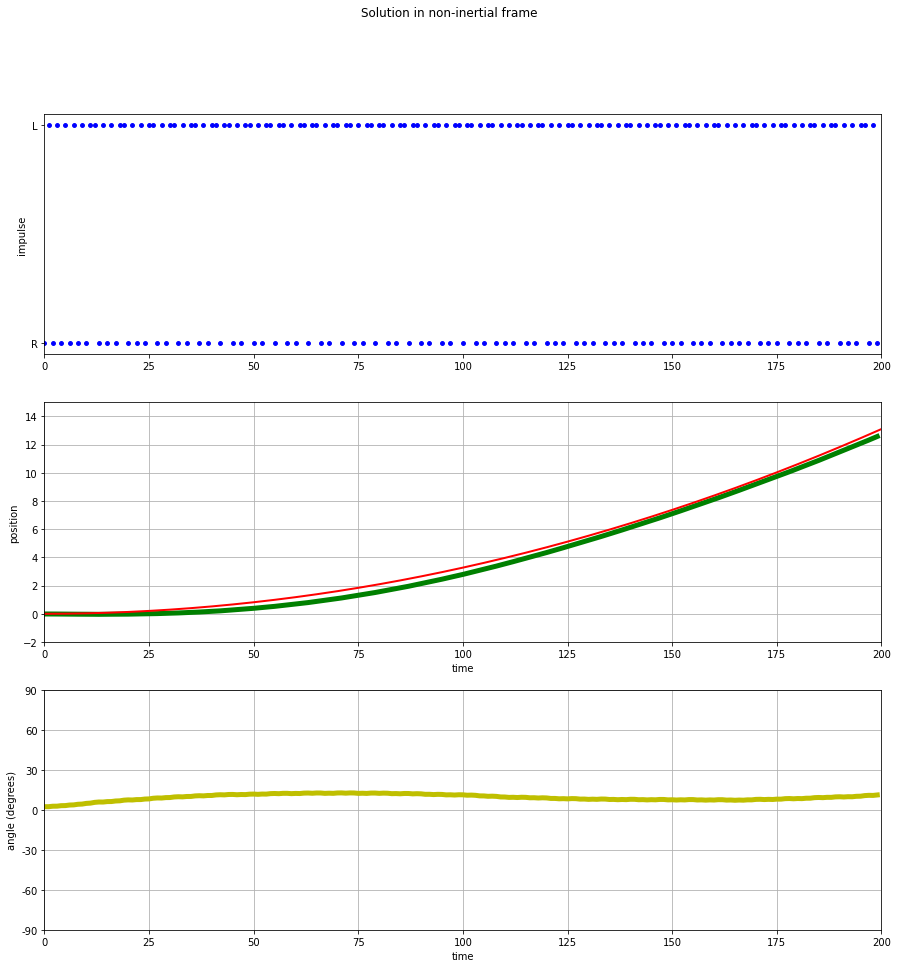

In [100]:
obs,choices,frames=an.play_a_round(model2)
_,axs=plt.subplots(3,1, figsize=(15,15))
axs[0].scatter(range(len(obs)),2*choices-1,s=15,color='b')
axs[0].set_xlim(0,200)
axs[0].set_ylabel('impulse')
axs[0].set_yticks([-1,1])
axs[0].set_yticklabels(['R','L'])


axs[1].plot(obs[:,0],lw=5,color='g')
axs[1].grid(True)
axs[1].set_xlabel('time')
axs[1].set_ylabel('position')
axs[1].set_xlim(0,200)
axs[1].set_ylim(-2,15)

lr=LinearRegression()
lr.fit(0.5*np.arange(200).reshape(-1,1)**2,obs[:,0])
t=np.linspace(0,200,1000)
y=lr.coef_*.5*t**2
axs[1].plot(t,y,lw=2,color='r')


axs[2].plot(obs[:,2],lw=5,color='y')
axs[2].grid(True)
axs[2].set_xlabel('time')
axs[2].set_ylabel('angle (degrees)')
axs[2].set_xlim(0,200)
axs[2].set_yticks(rad)
axs[2].set_yticklabels(thetas)
plt.suptitle('Solution in non-inertial frame')

In [101]:
plot_animation(frames)

As mentioned earlier, the model "runs" with the cart by accelerating it rightwards while maintaining a more or less constant non-zero angle.